In [1]:
## This file reads the stored ik npz file in dat_file and 
## plays the Ik trajectory
import time
import numpy as np
import pinocchio as pin
import crocoddyl

from matplotlib import pyplot as plt

from robot_properties_solo.config import Solo12Config

In [2]:
robot = Solo12Config.buildRobotWrapper()
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
viz.viewer.jupyter_cell()

In [55]:
f = np.load("dat_file/ik.npz")
xs = f["xs"]
for i in range(len(xs)):
    time.sleep(0.1)
    viz.display(xs[i][:robot.model.nq])

In [5]:
for i in range(len(xs)):
    q = xs[i][:robot.model.nq]
    v = xs[i][robot.model.nq:]
    pin.forwardKinematics(robot.model, robot.data, q, v)
    pin.updateFramePlacements(robot.model, robot.data)
#     print(pin.centerOfMass(robot.model, robot.data, q, v)[2], com_opt[i][2])
    pin.computeCentroidalMomentum(robot.model, robot.data)
    print(np.round(robot.data.hg, 2)[4])
#     print(np.array(pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId("FL_FOOT"), pin.LOCAL_WORLD_ALIGNED))[0:3])

0.0
-0.0
0.0
0.01
0.01
0.01
0.01
0.01
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [34]:
# Dynamic constraint violation validation
dt = 5e-2
f = np.load("dat_file/mom.npz")
mom_opt, com_opt, F_opt = f["mom_opt"], f["com_opt"], f["F_opt"]

rmass = pin.computeTotalMass(robot.model)
mom_opt[:,0:3] /= rmass

In [51]:
int_com = []
int_vel = []
int_vel.append(mom_opt[0,0:3])
int_com.append(com_opt[0])
cent_f = []
computed_cent_f = []
for i in range(1, len(com_opt)):
#     int_com.append(int_com[i-1] + dt*mom_opt[i-1][0:3])    
    int_com.append(int_com[i-1] + dt*int_vel[i-1])
    f = np.reshape(F_opt[12*(i-1):12*i], (12,))
    tmp = np.array([np.sum(f[0::3]), np.sum(f[1::3]), np.sum(f[2::3]) - rmass*9.81])
    cent_f.append(tmp)
    computed_cent_f.append(rmass*(mom_opt[i][2] - mom_opt[i-1][2])/dt)
    int_vel.append(int_vel[i-1] + (1/rmass)*dt*tmp)

int_vel = np.array(int_vel)   
int_com = np.array(int_com)
cent_f = np.array(cent_f)

print(int_com.shape, com_opt.shape)

(19, 3) (19, 3)


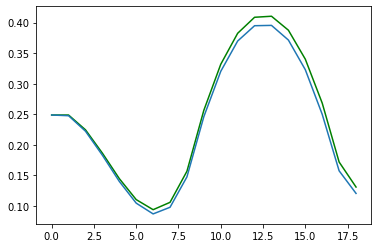

In [52]:
plt.plot(int_com[:,2], color = "green")
plt.plot(com_opt[:,2])

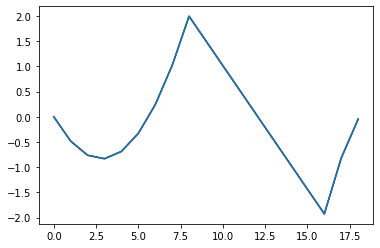

In [53]:
plt.plot(int_vel[:,2], color = "black")
plt.plot(mom_opt[:,2])

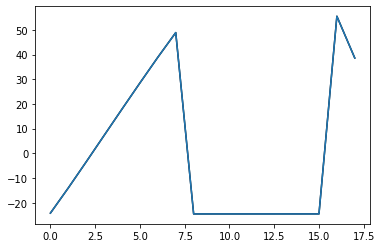

In [54]:
plt.plot(computed_cent_f, color = "black")
plt.plot(cent_f[:,2])

In [38]:
# bullet
bul_dt = 1e-3
f = np.load("dat_file/bul.npz")
com_bul, vel_bul, F_bul = f["Com_real"], f["dCom_real"], f["F_real"]

In [39]:
int_com = []
int_com.append(com_opt[0])
vel = mom_opt[0][0:3].copy()
for i in range(len(F_bul)):
    int_com.append(int_com[i] + vel*bul_dt)
    f = F_bul[i]
    tmp = -1*np.array([np.sum(f[0::3]), np.sum(f[1::3]), np.sum(f[2::3]) - rmass*9.81])
    if tmp[2] < 0:
        tmp[2] = 0
    vel += tmp*bul_dt
    
int_com = np.array(int_com)

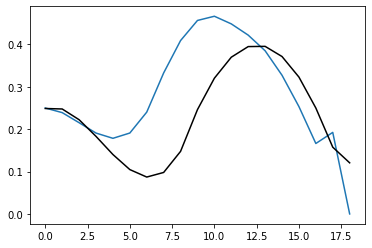

In [56]:
plt.plot(com_bul[::int(dt/bul_dt)][:,2][0:400])
plt.plot(com_opt[:,2], color = "black")

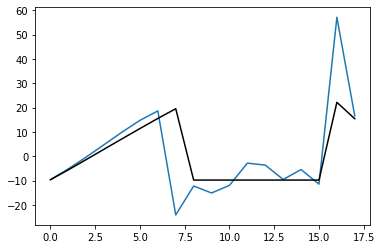

In [43]:
f_tmp = []
f_des_tmp = []
for i in range(len(vel_bul)-1):
    f_tmp.append((vel_bul[i+1][2] - vel_bul[i][2])/bul_dt)

plt.plot(f_tmp[::int(dt/bul_dt)])
plt.plot(cent_f[:,2]/rmass, color = "black")
# plt.ylim(-25, 100)